In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.constants import c

In [2]:
class SignalInformation ( object ): #lable of info the node stores in the Line class
    def __init__ (self,power,path):
        self._signal_power= power
        self._path= path
        self._noise_power= 0
        self._latency= 0

    @property
    def signal_power (self):
        return self._signal_power

    @property
    def path (self):
        return self._path

    @path.setter
    def path (self, path):
        self._path= path

    @property
    def noise_power (self):
        return self._noise_power

    @noise_power.setter
    def noise_power (self, noise):
        self._noise_power = noise

    @property
    def latency (self):
        return self._latency

    @latency.setter
    def latency (self, latency):
        self._latency= latency
    def add_noise (self , noise):
        self.noise_power += noise
    def add_latency (self , latency):
        self.latency += latency # add latency
    def next (self):
        self.path= self.path[1:] #path updating

In [3]:
class Node ( object ): #we keep a dictionary of nodes in the Network
    def __init__ (self , node_dict ):
        self._label= node_dict ['label']
        self._position= node_dict ['position']
        self._connected_nodes= node_dict ['connected_nodes']
        self._successive= {}

    @property
    def label (self):
        return self._label

    @property
    def position (self):
        return self._position

    @property
    def connected_nodes (self):
        return self._connected_nodes

    @property
    def successive (self): #link the node to the next one
        return self._successive

    @successive.setter
    def successive (self, successive ):
        self._successive = successive

    def propagate (self, signal_information):
        path= signal_information.path
        if len( path ) >1: #if there exist a successive node
            line_label= path [:2]
            line= self.successive [line_label]
            signal_information.next () #scroll the nodes up to the last one
            signal_information= line.propagate (signal_information)
        return signal_information

In [4]:
class Line ( object ): # manage the signal informations for a dictionary in Network
    def __init__ (self , line_dict ):
        self._label= line_dict ['label']
        self._length= line_dict ['length']
        self._successive= {}

    @property
    def label (self):
        return self._label

    @property
    def length (self):
        return self._length

    @property
    def successive (self):
        return self._successive

    @successive.setter
    def successive (self, successive ):
        self._successive= successive

    def latency_generation ( self ):
        latency= self.length / (c * 2 / 3)
        return latency

    def noise_generation (self, signal_power ):
        noise= 1e-3 * signal_power * self.length
        return noise

    def propagate (self, signal_information ):
    # Update latency
        latency = self.latency_generation ()
        signal_information.add_latency ( latency )
    # Update noise
        signal_power = signal_information.signal_power
        noise = self.noise_generation (signal_power)
        signal_information.add_noise (noise)
        node = self.successive [signal_information.path [0]]
        signal_information = node.propagate (signal_information)
        return signal_information

In [6]:
class Network ( object ): #them main class that contains all the nodes and info
    def __init__ (self, json_path, free_list ):
        node_json = json.load ( open ( json_path ,'r'))
        self._nodes = {}
        self._lines = {}
        self._graph = {}
        
        for node_label in node_json:
            # Create the node instance
            node_dict = node_json [ node_label ]
            node_dict ['label'] = node_label
            node = Node ( node_dict )
            self._nodes [ node_label ] = node
            # Create the line instances
            for connected_node_label in node_dict ['connected_nodes']:
                line_dict ={}
                line_label = node_label + connected_node_label
                line_dict ['label'] = line_label
                node_position = np. array ( node_json [ node_label ]['position'])
                connected_node_position = np.array ( node_json [ connected_node_label ]['position'])
                line_dict ['length'] = np.sqrt (
                    np.sum (( node_position - connected_node_position )**2) #Pitagora distance formula
                    )
                line_dict['state']= 'free' #default value
                for free in free_list:
                    if(node_label== free[0] and connected_node_label== free[1]):
                        line_dict['state']= 'occupied'
                line = Line ( line_dict )
                self._lines [ line_label ] = line

    @property
    def nodes ( self ):
        return self._nodes 
    @property
    def lines ( self ):
        return self._lines
    def draw ( self ):
        nodes = self.nodes
        plt. figure ()
        for node_label in nodes :
            n0 = nodes [ node_label ]
            x0 = n0.position [0]
            y0 = n0.position [1]
            plt.plot (x0 ,y0 ,'go',markersize =10)
            plt.text (x0 +20 , y0 +20 , node_label )
            for connected_node_label in n0.connected_nodes :
                n1 = nodes [ connected_node_label ]
                x1 = n1. position [0]
                y1 = n1. position [1]
                plt.plot ([x0 ,x1 ] ,[y0 ,y1] ,'b')
        plt.title ('Network')
        plt. xlabel ('x amplitude [m]')
        plt. ylabel ('y amplitude [m]')
        plt.show ()
        
    def find_paths (self ,label1 , label2 ):
        cross_nodes = [key for key in self.nodes.keys ()
                        if (( key != label1 ) & ( key != label2 ))]
        cross_lines = self.lines.keys ()
        inner_paths = {'0': label1 }
        for i in range (len ( cross_nodes )+1):
            inner_paths [str(i +1)] = []
            for inner_path in inner_paths [str (i)]:
                inner_paths [str(i +1)]+= [ inner_path + cross_node
                    for cross_node in cross_nodes
                    if (( inner_path [ -1]+ cross_node in cross_lines ) & ( cross_node not in inner_path ))]
        paths = []
        for i in range (len ( cross_nodes )+1):
            for path in inner_paths [str (i)]:
                if path [ -1] + label2 in cross_lines :
                    paths.append ( path + label2 )
        return paths
    
    def connect ( self ):
        nodes_dict = self.nodes
        lines_dict = self.lines
        for node_label in nodes_dict :
            node = nodes_dict [ node_label ]
            for connected_node in node.connected_nodes :
                line_label = node_label + connected_node
                line = lines_dict [ line_label ]
                line.successive [ connected_node ] = nodes_dict [ connected_node ]
                node.successive [ line_label ] = lines_dict [ line_label ]
    def propagate (self , signal_information ):
        path = signal_information.path
        start_node = self.nodes [ path [0]]
        propagated_signal_information = start_node.propagate (signal_information)
        return propagated_signal_information 
      
    @property
    def graph ( self ):
        return self._graph #for now it is unlinked to graph = Connection()
    
    def network_generate ( self ):
        self.connect ()
        node_labels = self.nodes.keys ()
        pairs = []
        for label1 in node_labels:
            for label2 in node_labels:
                if label1 != label2 :
                    pairs.append ( label1 + label2 )
        columns = ['path','latency','noise','snr']
        df = pd. DataFrame ()
        paths = []
        node1 = []
        node2 = []
        latencies = []
        noises = []
        snrs = []

        for pair in pairs :
            for path in self.find_paths ( pair[0] , pair[1]):
                path_string = ''
                node1.append (path[0])
                for node in path :
                    path_string += node + '->'
                paths.append ( path_string [: -2]) #create a pandas dataframe as "A->B-> ..."
                node2.append (node)

                # Propagation
                signal_information = SignalInformation (1e-3, path )
                signal_information = self.propagate ( signal_information )
                latencies.append ( signal_information.latency )
                noises.append ( signal_information.noise_power )
                snrs.append (10* np.log10 (signal_information.signal_power / signal_information.noise_power))
        df['path'] = paths
        df['node1'] = node1
        df['node2'] = node2
        df['latency'] = latencies
        df['noise'] = noises
        df['snr'] = snrs
        return df
    
    def check_free ( self, path ):
        for line in self.lines.keys():
            for L in range(0,len(path)-3,3): #check every node avoiding the arrows ->
                if ((line[0]==path[L]) & (line[1]==path[L+3]) & (self.lines[line].state != 'free')):
                    return 1
        return 0
    
    def find_best_snr( self ,Label1, Label2, free_flag='no' ):
        snrs=[] #list of all the snr from lable1 to lable2
        for ii in range(0, len(df.path)-1):
            if((df.node1[ii]==Label1) & (df.node2[ii]==Label2)):
                if(free_flag== 'yes'):
                    if(self.check_free(df.path[ii])==0):
                        snrs.append(df.snr[ii])
                else:
                    snrs.append(df.snr[ii])
        
        if not snrs: #no avaible paths, snr set to -inf
            snr=-9999
        else:
            snr= max(snrs) #get highest snr in first place
        return snr
    
    def find_best_latency( self ,Label1, Label2, free_flag='no' ):
        lats=[] #list of all the latency from lable1 to lable2
        for ii in range(0, len(df.path)-1):
            if((df.node1[ii]==Label1) & (df.node2[ii]==Label2)):
                if(free_flag== 'yes'):
                    if(self.check_free(df.path[ii])==0):
                        lats.append(df.latency[ii])
                else:
                    lats.append(df.latency[ii])
        
        if not lats: #no avaible paths, lat set to +inf
            lat=9999
        else:
            lat= min(lats) #get lowest latency in first place
        return lat
    
    def stream (self, conn_list, index, label='lat', free_flag ='no'): #4.5 given a list of connection it computes best 'lat' or best 'srn'
        paths= self.find_paths(conn_list[index].input_node, conn_list[index].output_node)
        for path in paths:
            # Propagation
            signal_information= SignalInformation (conn_list[index].signal_power , path )
            signal_information= self.propagate ( signal_information )
            
        if label=='lat':
            out_num= self.find_best_latency( conn_list[index].input_node, conn_list[index].output_node, free_flag)
            conn_list[index].add_latency(out_num)
        else:
            out_num= self.find_best_snr( conn_list[index].input_node, conn_list[index].output_node, free_flag)
            conn_list[index].add_snr(out_num)
        return out_num

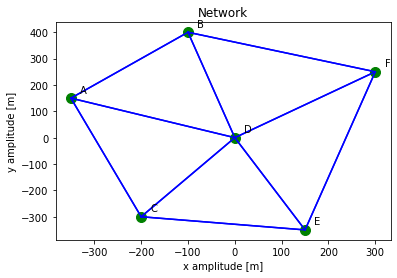

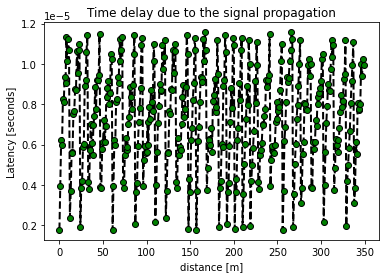

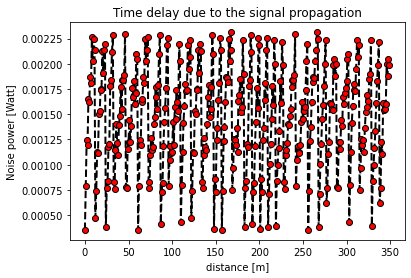

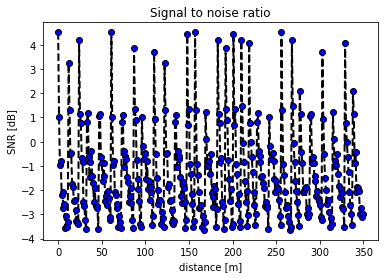

In [6]:
network = Network ('nodes.json')
network.connect ()
node_labels = network.nodes.keys ()
pairs = []
for label1 in node_labels:
    for label2 in node_labels:
        if label1 != label2 :
            pairs.append ( label1 + label2 )
columns = ['path','latency','noise','snr']
df = pd. DataFrame ()
paths = []
latencies = []
noises = []
snrs = []

for pair in pairs :
    for path in network.find_paths ( pair[0] , pair[1]):
        path_string = ''
        for node in path :
            path_string += node + '->'
        paths.append ( path_string [: -2]) #create a pandas dataframe as "A->B-> ..."
        
        # Propagation
        signal_information = SignalInformation (1e-3, path )
        signal_information = network.propagate ( signal_information )
        latencies.append ( signal_information.latency )
        noises.append ( signal_information.noise_power )
        snrs.append (10* np.log10 (signal_information.signal_power / signal_information.noise_power))
df['path'] = paths
df['latency'] = latencies
df['noise'] = noises
df['snr'] = snrs

network.draw() # draw the network using matplotlib (nodes as dots and connection as lines)

plt. figure ()
plt.plot(latencies,color ='k', marker ='o', markerfacecolor ='g',linestyle ='--', linewidth =2)
plt. title  ('Time delay due to the signal propagation')
plt. xlabel ('distance [m]')
plt. ylabel ('Latency [seconds]')

plt. figure ()
plt.plot(noises,color ='k', marker ='o', markerfacecolor ='r',linestyle ='--', linewidth =2)
plt. title  ('Noise Power')
plt. xlabel ('distance [m]')
plt. ylabel ('Noise power [Watt]')

plt. figure ()
plt.plot(snrs,color ='k', marker ='o', markerfacecolor ='b',linestyle ='--', linewidth =2)
plt. title  ('Signal to noise ratio')
plt. xlabel ('distance [m]')
plt. ylabel ('SNR [dB]')
plt. show()

In [7]:
df

,path,latency,noise,snr
0,A->B,0.000002,0.000354,4.515450
1,A->D->B,0.000004,0.000793,1.006725
2,A->C->D->B,0.000006,0.001247,-0.959387
3,A->D->F->B,0.000006,0.001199,-0.786385
4,A->C->D->F->B,0.000008,0.001653,-2.181702
...,...,...,...,...
345,F->D->A->C->E,0.000008,0.001599,-2.039017
346,F->B->A->C->D->E,0.000010,0.001996,-3.002560
347,F->B->A->D->C->E,0.000009,0.001876,-2.731520
348,F->B->D->A->C->E,0.000010,0.002048,-3.113712
